In [11]:
import pennylane as qml
from autograd import grad

In [12]:
################ Code from the 'Optimization of molecular geometries' tutorial##################
# imports and relevant defines:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

# Simulation starting parameters:
symbols = ["Be", "H", "H"]

# np.array([ 0.8765    ,  1.9857    , -2.4895    ,  0.83258936,  0.27791693,
#        -2.71614899,  0.9293593 ,  3.70744234, -2.5407848 ], requires_grad=True)

# this is selected from the tutorial 'Building molecular Hamiltonians', which has the same nulcear-coordinats for water
x = np.array([[0.8765    ,  1.9857    , -2.4895],
              [0.83258936,  0.27791693, -2.71614899],
              [0.9293593 ,  3.70744234, -2.5407848]], requires_grad=True)
# these parameters are used to match up with the parameters for the VQE run on water in the paper: https://arxiv.org/pdf/2106.13840.pdf
active_electrons = 4
active_orbitals = 6

# define the hamiltonian needed to compute cost-function
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons,
                                           active_orbitals = active_orbitals)[0]

hf = qml.qchem.hf_state(electrons=active_electrons, orbitals=active_orbitals*2)
print(hf)

[1 1 1 1 0 0 0 0 0 0 0 0]


In [13]:
# Need to run this: functions to allow us to calculate angle between OH1 and OH2:
import math

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/math.pi) #convert to degrees

In [14]:
################ Code from the 'Building the adaptive circuit' tutorial below:################
active_electrons = active_electrons
active_orbitals = active_orbitals

H, qubits = qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)
singles, doubles = qchem.excitations(active_electrons, qubits)

hf_state = qchem.hf_state(active_electrons, qubits)
print(hf_state)



#compute the significant double-excitation gates:
def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)

dev = qml.device("default.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)
print("Computed gradients for all possible Double Excitation Gates: \n")
for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")   
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected double-excitation gates: ", len(doubles_select))



# optimizing the parameters for the double-excitation gates for Ansatz-wavefunction construction
opt = qml.GradientDescentOptimizer(stepsize=0.5)
params_doubles = np.zeros(len(doubles_select), requires_grad=True)
for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
print("Done!")



#compute the significant single-excitation gates:
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)


cost_fn = qml.QNode(circuit_2, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)
grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)
print("Computed gradients for all possible Single Excitation Gates: \n")
for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected single-excitation gates: ", len(singles_select))

#Total Number of Gates selected to construct the Quantum Ansatz:
print("Total selected gates: "+  str(len(doubles_select) + len(singles_select)))

################# End code from the 'Building the adaptive circuit' tutorial ##################

[1 1 1 1 0 0 0 0 0 0 0 0]
Computed gradients for all possible Double Excitation Gates: 

Excitation : [0, 1, 4, 5], Gradient: -0.05675774547928986
Excitation : [0, 1, 4, 7], Gradient: 0.0
Excitation : [0, 1, 4, 9], Gradient: 0.000741991486460103
Excitation : [0, 1, 4, 11], Gradient: 0.0
Excitation : [0, 1, 5, 6], Gradient: 0.0
Excitation : [0, 1, 5, 8], Gradient: -0.000741991486460103
Excitation : [0, 1, 5, 10], Gradient: 0.0
Excitation : [0, 1, 6, 7], Gradient: -0.05725210270187538
Excitation : [0, 1, 6, 9], Gradient: 0.0
Excitation : [0, 1, 6, 11], Gradient: 0.0
Excitation : [0, 1, 7, 8], Gradient: 0.0
Excitation : [0, 1, 7, 10], Gradient: 0.0
Excitation : [0, 1, 8, 9], Gradient: -0.07077033797425428
Excitation : [0, 1, 8, 11], Gradient: 0.0
Excitation : [0, 1, 9, 10], Gradient: 0.0
Excitation : [0, 1, 10, 11], Gradient: -0.05790194720065484
Excitation : [0, 2, 4, 6], Gradient: 0.0
Excitation : [0, 2, 4, 8], Gradient: 0.0
Excitation : [0, 2, 4, 10], Gradient: 0.005192956578481277
Exc

In [21]:
# End of ADAPT VQE ^ 
# Now use Soran's modified code down below:


symbols = ["Be", "H", "H"]
geometry = np.array([[0.8765    ,  1.9857    , -2.4895],
              [0.83258936,  0.27791693, -2.71614899],
              [0.9293593 ,  3.70744234, -2.5407848]], requires_grad=True)
mol = qml.qchem.Molecule(symbols, geometry)
dev = qml.device("default.qubit")

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

In [22]:
def energy(mol):
    @qml.qnode(dev, interface="autograd")
    def circuit(*args):
        
        # note that active_electrons=2, active_orbitals=2 in this example
        qml.BasisState(hf_state, wires=range(qubits))
        
        # apply all single excitations
        for i, singles in enumerate(singles_select):
            qml.SingleExcitation(*args[0][i], wires=singles)
            
        # apply all double excitations
        for j, doubles in enumerate(doubles_select):
            qml.DoubleExcitation(*args[0][j + len(singles_select)], wires=doubles)
        
        # note that active_electrons=2, active_orbitals=2 in this example
        H = qml.qchem.molecular_hamiltonian(mol.symbols, mol.coordinates,
            active_electrons=active_electrons, active_orbitals=active_orbitals, args=args[1:])[0]
        
        return qml.expval(H)
    return circuit

In [23]:
# number of zeros should match the number of circuit gates
circuit_param = [np.array([0.0], requires_grad=True)] * (len(singles_select) + len(doubles_select))
# THIS LINE MADE THE DIFFERENCE IN THE CODE:

# Starting bond-length and bond-angle:
BeH1 = geometry[0] - geometry[1]
BeH2 = geometry[0] - geometry[2]
angle = 360-angle_between(BeH1, BeH2)
BeH1_length = np.linalg.norm(BeH1) * bohr_angs
print(f"Starting Bond length = {BeH1_length:.5f} A, Starting Bond angle = {angle:.5f}" + '\u00b0')
print("")

energy_vec = []
bond_length = []
bond_angle = []

eps = 1e-05
n = 0

theta_learning_rate = 0.4
x_learning_rate = 0.5

start = time.time()
while True:
    args = [circuit_param, geometry]
    mol = qml.qchem.Molecule(symbols, geometry)

    g_param = grad(energy(mol), argnum = 0)(*args)
    circuit_param = circuit_param - theta_learning_rate * g_param[0]

    forces = -grad(energy(mol), argnum = 1)(*args)
#     geometry = geometry + 0.05 * forces
    geometry = geometry + x_learning_rate * forces
    
    
    energy_recalc = energy(mol)(*args)
    print(f'n: {n}, E: {energy_recalc:.8f}, Force-max: {abs(forces).max():.8f}')
    
    # Re-Compute molecule characteristics:
    BeH1 = geometry[0] - geometry[1]
    BeH2 = geometry[0] - geometry[2]
    angle = 360-angle_between(BeH1, BeH2)
    BeH1_length = np.linalg.norm(BeH1) * bohr_angs
    
    # Add results to array:
    energy_vec.append(energy_recalc)
    bond_length.append(BeH1_length)
    bond_angle.append(angle)
    
    print(f"Bond length = {BeH1_length:.5f} A, Bond angle = {angle:.5f}" + '\u00b0')
    print("")
    
    n += 1
    if n <= 1:
        continue
    #if np.max(np.abs(forces)) <= 1e-05 or np.abs(energy_vec[-2]-energy_vec[-1]) < eps:
    if np.max(np.abs(forces)) <= 1e-05:
        print("Successfully converged!")
        break
        
print("Total time:", time.time()-start, "seconds")

print("\n" f"Final value of the ground-state energy = {energy_vec[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[i][0]:.4f}   {x[i][1]:.4f}   {x[0][2]:.4f}")

Starting Bond length = 0.91194 A, Starting Bond angle = 189.26710°

n: 0, E: -15.35505119, Force-max: 0.37336183
Bond length = 1.01189 A, Bond angle = 190.56741°

n: 1, E: -15.46476163, Force-max: 0.21862410
Bond length = 1.07044 A, Bond angle = 191.18553°

n: 2, E: -15.50538325, Force-max: 0.15218135
Bond length = 1.11114 A, Bond angle = 191.48372°

n: 3, E: -15.52569834, Force-max: 0.11398189
Bond length = 1.14155 A, Bond angle = 191.59546°

n: 4, E: -15.53729420, Force-max: 0.08902910
Bond length = 1.16522 A, Bond angle = 191.58786°

n: 5, E: -15.54444881, Force-max: 0.07147215
Bond length = 1.18415 A, Bond angle = 191.49986°

n: 6, E: -15.54909984, Force-max: 0.05849862
Bond length = 1.19958 A, Bond angle = 191.35604°

n: 7, E: -15.55224046, Force-max: 0.04865718
Bond length = 1.21234 A, Bond angle = 191.17287°

n: 8, E: -15.55442421, Force-max: 0.04093240
Bond length = 1.22300 A, Bond angle = 190.96184°

n: 9, E: -15.55597901, Force-max: 0.03474255
Bond length = 1.23199 A, Bond an

n: 85, E: -15.56134293, Force-max: 0.00091467
Bond length = 1.29050 A, Bond angle = 180.97764°

n: 86, E: -15.56134355, Force-max: 0.00088544
Bond length = 1.29051 A, Bond angle = 180.94638°

n: 87, E: -15.56134413, Force-max: 0.00085714
Bond length = 1.29051 A, Bond angle = 180.91612°

n: 88, E: -15.56134468, Force-max: 0.00082975
Bond length = 1.29051 A, Bond angle = 180.88682°

n: 89, E: -15.56134519, Force-max: 0.00080323
Bond length = 1.29051 A, Bond angle = 180.85846°

n: 90, E: -15.56134566, Force-max: 0.00077755
Bond length = 1.29051 A, Bond angle = 180.83101°

n: 91, E: -15.56134611, Force-max: 0.00075270
Bond length = 1.29052 A, Bond angle = 180.80443°

n: 92, E: -15.56134653, Force-max: 0.00072864
Bond length = 1.29052 A, Bond angle = 180.77871°

n: 93, E: -15.56134693, Force-max: 0.00070535
Bond length = 1.29052 A, Bond angle = 180.75380°

n: 94, E: -15.56134729, Force-max: 0.00068280
Bond length = 1.29052 A, Bond angle = 180.72970°

n: 95, E: -15.56134764, Force-max: 0.000

n: 170, E: -15.56135275, Force-max: 0.00005774
Bond length = 1.29054 A, Bond angle = 180.06170°

n: 171, E: -15.56135275, Force-max: 0.00005589
Bond length = 1.29054 A, Bond angle = 180.05972°

n: 172, E: -15.56135275, Force-max: 0.00005411
Bond length = 1.29054 A, Bond angle = 180.05781°

n: 173, E: -15.56135275, Force-max: 0.00005238
Bond length = 1.29054 A, Bond angle = 180.05596°

n: 174, E: -15.56135275, Force-max: 0.00005070
Bond length = 1.29054 A, Bond angle = 180.05417°

n: 175, E: -15.56135276, Force-max: 0.00004908
Bond length = 1.29054 A, Bond angle = 180.05244°

n: 176, E: -15.56135276, Force-max: 0.00004751
Bond length = 1.29054 A, Bond angle = 180.05076°

n: 177, E: -15.56135276, Force-max: 0.00004599
Bond length = 1.29054 A, Bond angle = 180.04914°

n: 178, E: -15.56135276, Force-max: 0.00004452
Bond length = 1.29054 A, Bond angle = 180.04757°

n: 179, E: -15.56135276, Force-max: 0.00004310
Bond length = 1.29054 A, Bond angle = 180.04605°

n: 180, E: -15.56135276, Force

In [43]:
bond_length[-1], bond_angle[-1]

(1.2905383619600228, 180.0106641278839)

In [45]:
len(bond_length)

225

In [19]:
circuit_param = [np.array([0.0], requires_grad=True)] * (len(singles_select) + len(doubles_select))

In [20]:
def function(*args):
    print(*args[0][0])
function(*args)           

0.0


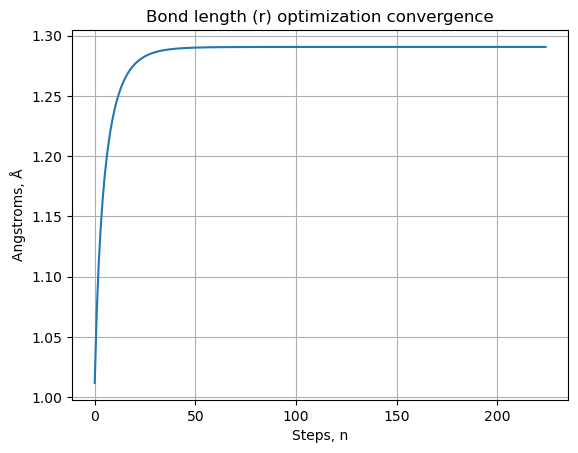

In [24]:
import matplotlib.pyplot as plt
np_bl = np.array(bond_length)
np_ba = np.array(bond_angle)
np_en = np.array(energy_vec)
plt.plot(np_bl)
plt.xlabel("Steps, n")
plt.ylabel("Angstroms, Å")
plt.title("Bond length (r) optimization convergence")
plt.grid(True)

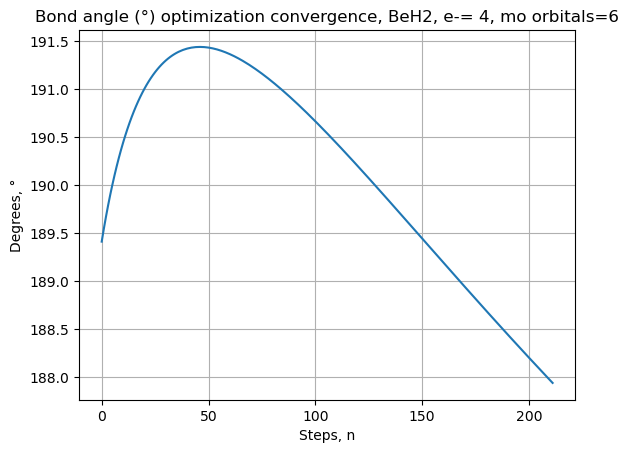

In [22]:
plt.plot(np_ba)
plt.xlabel("Steps, n")
plt.ylabel("Degrees, \u00b0")
plt.title("Bond angle (\u00b0) optimization convergence, BeH2, e-= 4, mo orbitals=6")
plt.grid(True)

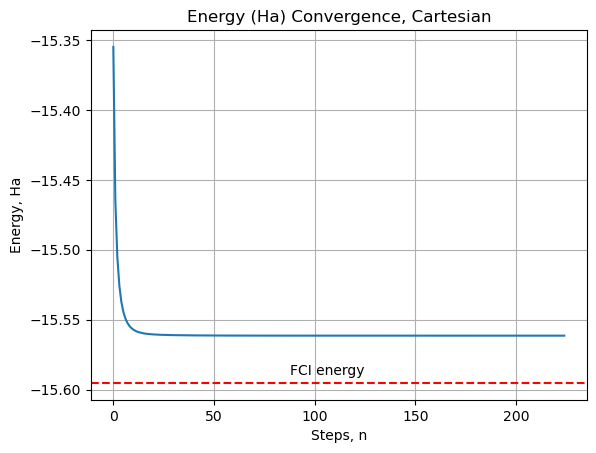

In [38]:
plt.plot(np_en)
plt.xlabel("Steps, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) Convergence, Cartesian")

plt.axhline(y=-15.59512681225857, color='r', linestyle='--')
plt.text(125, -15.589, 'FCI energy', horizontalalignment='right')

plt.grid(True)

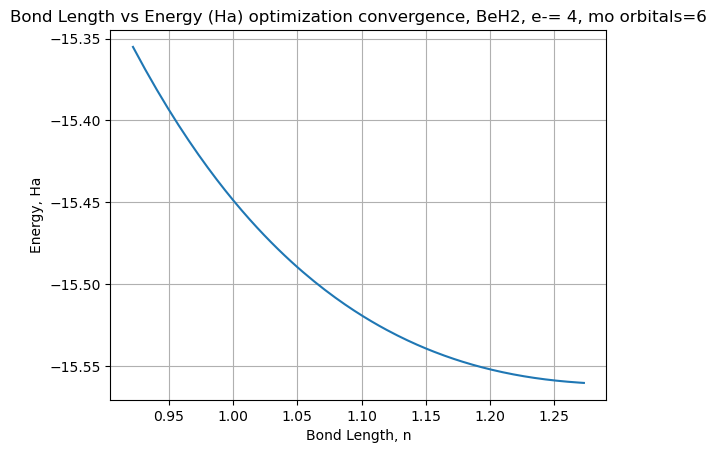

In [24]:
plt.plot(np_bl, np_en)
plt.xlabel("Bond Length, n")
plt.ylabel("Energy, Ha")
plt.title("Bond Length vs Energy (Ha) optimization convergence, BeH2, e-= 4, mo orbitals=6")
plt.grid(True)

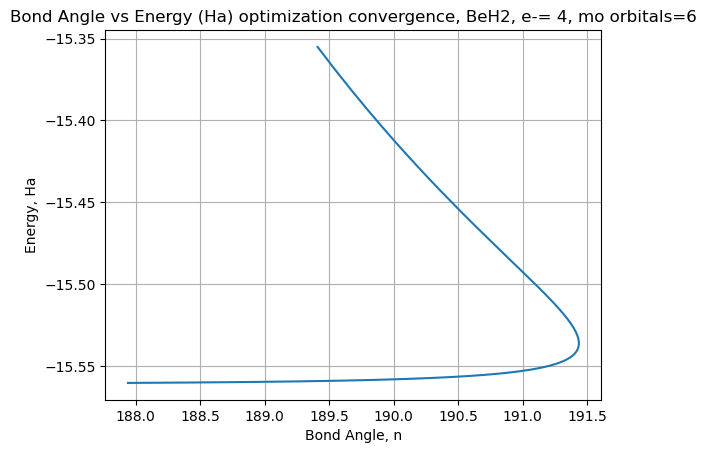

In [25]:
plt.plot(np_ba, np_en)
plt.xlabel("Bond Angle, n")
plt.ylabel("Energy, Ha")
plt.title("Bond Angle vs Energy (Ha) optimization convergence, BeH2, e-= 4, mo orbitals=6")
plt.grid(True)

In [33]:
f(X, Y)

array([[ 8.07261091e-01,  9.41437765e-01,  9.97705708e-01,
         9.80850719e-01,  9.02160390e-01,  7.77003505e-01,
         6.22348946e-01,  4.54593535e-01,  2.87954298e-01,
         1.33543814e-01, -8.84706779e-04, -1.10640850e-01,
        -1.93431827e-01, -2.48533645e-01, -2.75989644e-01,
        -2.75989644e-01, -2.48533645e-01, -1.93431827e-01,
        -1.10640850e-01, -8.84706779e-04,  1.33543814e-01,
         2.87954298e-01,  4.54593535e-01,  6.22348946e-01,
         7.77003505e-01,  9.02160390e-01,  9.80850719e-01,
         9.97705708e-01,  9.41437765e-01,  8.07261091e-01],
       [ 9.41437765e-01,  9.98937218e-01,  9.71132423e-01,
         8.69941049e-01,  7.12998635e-01,  5.20584150e-01,
         3.12742785e-01,  1.07000578e-01, -8.30932252e-02,
        -2.48533645e-01, -3.84629319e-01, -4.90176225e-01,
        -5.66292335e-01, -6.15169883e-01, -6.38962142e-01,
        -6.38962142e-01, -6.15169883e-01, -5.66292335e-01,
        -4.90176225e-01, -3.84629319e-01, -2.48533645e-

In [20]:
from mpl_toolkits import mplot3d
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

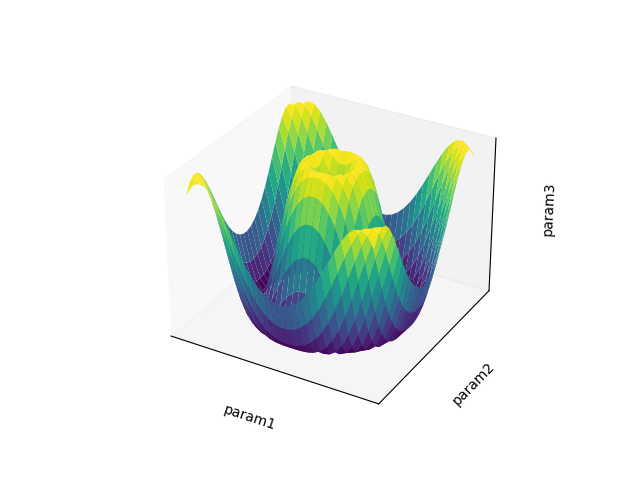

In [26]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('param1')
ax.set_ylabel('param2')
ax.set_zlabel('param3');

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

# generate some sample data
import scipy.misc
lena = cv2.imread("./data/lena.png", 0)

# downscaling has a "smoothing" effect
lena = cv2.resize(lena, (100,100))

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:lena.shape[0], 0:lena.shape[1]]

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, lena ,rstride=1, cstride=1, cmap=plt.cm.jet,
                linewidth=0)

# show it
plt.show()

[ WARN:0@0.083] global /croot/opencv-suite_1691620365762/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data/lena.png'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /croot/opencv-suite_1691620365762/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


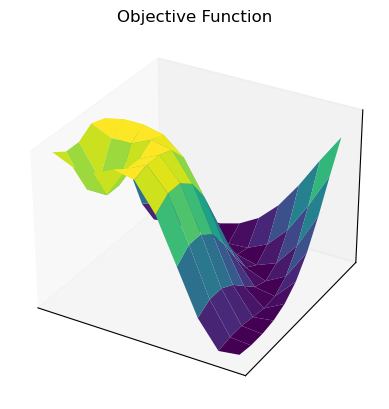

In [2]:


# from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# function for z axis
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))
 
# x and y axis
x = np.linspace(-1, 5, 10)
y = np.linspace(-1, 5, 10)
  
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
 
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title('Objective Function');
# ax.set_xlabel('param1')
# ax.set_ylabel('param2')
# ax.set_zlabel('param3');

In [5]:
def f(x):
    return 5*x**2 + 10

# Generate x values
x = np.linspace(-2, 4, 400)

# Generate y values
y = f(x)


([], [])

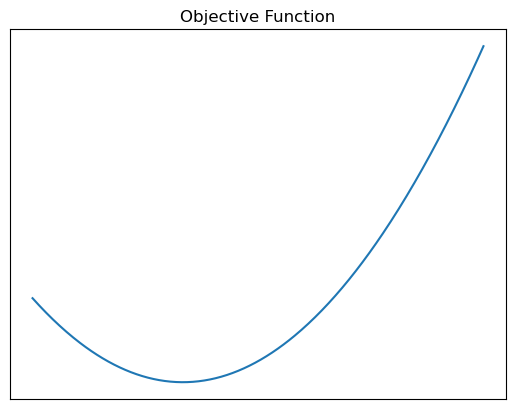

In [10]:
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.title("Objective Function")
plt.grid(False)
plt.xticks([])
plt.yticks([])

In [41]:
geometry1 = np.array([[0.8765    ,  1.9857    , -2.4895],
              [0.83258936,  0.27791693, -2.71614899],
              [0.9293593 ,  3.70744234, -2.5407848]], requires_grad=True)

In [42]:
H = qml.qchem.molecular_hamiltonian(symbols, geometry1)[0]
H_coeffs, H_ops = H.terms()
m = qml.resource.estimate_shots(H_coeffs)
print(f'Shots : {m:.2e}')

Shots : 3.76e+08
